<a href="https://colab.research.google.com/github/SolisProcopioUriel/Modelaci-n-financiera/blob/main/Modelo_Binomial_Black_and_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
from scipy.stats import binom
from scipy.stats import norm
import matplotlib.pyplot as plt

#PEDIMOS DATOS AL USUARIO

In [69]:
S_0 = float(input("Digite el valor de S_0(Precio actual): "))
k = float(input("Digite k(precio de ejercicio): "))
r = float(input("Digite r(tasa libre de riesgo) en porcentaje(Ejemplo 15%): "))
r = r/100
T = float(input("Digite el tiempo en meses(T): "))
T = T/12
n = int(input("Digite el número de periodos(n): "))
dt = T/n

valor_ud = input("¿Tienes valores de 'u' y 'd'?  Responder 's' en caso de tenerlos y 'n' en caso de no tenerlos: ")
if valor_ud == 's':
    u = float(input("Digite el valor de u(factor de subida): "))
    d = float(input("Digite el valor de d(factor de bajada): "))
    u = 1 + (u/100)
    d = 1 - (d/100)
    sigma = math.log(u)/math.sqrt(dt)
else:
    sigma = float(input("Digite el valor de la volatilidad en porcentaje(Ejemplo 15 si fuera 15%): "))
    sigma = sigma/100
    u = np.exp(sigma * math.sqrt(dt))
    d = 1/u

Tipo = input("De que tipo es: 'p' si es PUT y 'c' si es un CALL: ")
if Tipo == 'p':
    tc = 1
else:
    tc = -1
Clase = input("De que clase es: 'a' si es AMERICANO y 'e' si es EUROPEO: ")

Digite el valor de S_0(Precio actual): 158
Digite k(precio de ejercicio): 167
Digite r(tasa libre de riesgo) en porcentaje(Ejemplo 15%): 12
Digite el tiempo en meses(T): 10
Digite el número de periodos(n): 100
¿Tienes valores de 'u' y 'd'?  Responder 's' en caso de tenerlos y 'n' en caso de no tenerlos: n
Digite el valor de la volatilidad en porcentaje(Ejemplo 15 si fuera 15%): 36
De que tipo es: 'p' si es PUT y 'c' si es un CALL: c
De que clase es: 'a' si es AMERICANO y 'e' si es EUROPEO: e


#ALGUNOS CALCULOS

In [70]:
p = (math.exp(r * dt) - d)/(u - d)

vp = math.exp(- n * r * dt)

#ARBOL DE PRECIOS

In [71]:
def calcular_arbol_precios(S_0, u, d, n):
    precios = [[0.0 for _ in range(i + 1)] for i in range(n + 1)]
    for i in range(n + 1):
        for j in range(i + 1):
            precios[i][j] = S_0 * (u ** j) * (d ** (i - j))
    return precios

precios = calcular_arbol_precios(S_0, u, d, n)
arbol = "\nÁrbol Binomial de Precios:\n"
for i in range(n + 1):
    espacios = " " * (n - i) * 3   # Ajusta el espacio para la visualización
    arbol += espacios
    for j in range(i + 1):
        arbol += f"{precios[i][j]:.4f}\t"
    arbol += "\n"

#print(arbol)

#PAGOS DE LA ULTIMA COLUMNA

In [72]:
def calcular_pagos_finales(precios, n, k, tc):
    pagos_finales = [0.0 for _ in range(n + 1)]
    for j in range(n + 1):
        pagos_finales[j] = max(0, (tc * k) - (tc * precios[n][j]))
    return pagos_finales

pagos_finales = calcular_pagos_finales(precios, n, k, tc)
#print(pagos_finales)

#AMERICNANAS

In [73]:
def calcular_opcion_americana(precios, n, k, pagos_finales, p, r, dt, tc):
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            beneficio_ejercicio = max(0, tc*k - tc*precios[i][j])  # Beneficio al ejercer la opción PUT
            valor_operacion = math.exp(-r * dt) * (p * pagos_finales[j + 1] + (1 - p) * pagos_finales[j])

            # Para el PUT Americano, considerar el ejercicio óptimo en cualquier momento
            if tc == 1 and beneficio_ejercicio > valor_operacion:
                pagos_finales[j] = beneficio_ejercicio
            else:
                pagos_finales[j] = valor_operacion

    return pagos_finales[0]
pagos_finales = calcular_pagos_finales(precios, n, k, tc)
precio_a = calcular_opcion_americana(precios, n, k, pagos_finales, p, r, dt, tc)

#print("El valor de la opción AMERICANA es:", precio_a)

#EUROPEAS

In [74]:
def calcular_opcion_europea(pagos_finales, n, p, r, vp, dt):
    precio_e = 0
    for i in range(n + 1):
        precio_e += pagos_finales[i] * binom.pmf(i, n, p)

    precio_e *= vp
    return precio_e

precios = calcular_arbol_precios(S_0, u, d, n)
pagos_finales = calcular_pagos_finales(precios, n, k, tc)
precio_e = calcular_opcion_europea(pagos_finales, n, p, r, vp, dt)
#print(precio_e)

#IMPRIMIR RESULTADOS SEGUN LOS DATOS PROPORCIONADOS POR EL USUARIO

In [75]:
if Tipo == 'p' and Clase == 'a':
  print("El valor del PUT AMERICANA es: ", precio_a)
elif Tipo == 'p' and Clase == 'e':
  print("El valor del PUT EUROPEO es: ", precio_e)
elif Tipo == 'c' and Clase == 'a':
  print("El valor del CALL AMERICANO es: ", precio_a)
else:
  print("El valor del CALL EUROPEO es: ", precio_e)

if n <= 7:
    print(arbol)
else:
    print("El arbol es demaciado grande para graficar")

El valor del CALL EUROPEO es:  23.797384647750775
El arbol es demaciado grande para graficar


#PARIDAD PUT-CALL

\begin{equation}
  p + ke^{-rT} = c +S_0
\end{equation}

In [76]:
pagos_finales = calcular_pagos_finales(precios, n, k, -1)
precio_a_1 = calcular_opcion_americana(precios, n, k, pagos_finales, p, r, dt, -1)
print("CALL AMERICANO: ", precio_a_1)

pagos_finales = calcular_pagos_finales(precios, n, k, 1)
precio_a_3 = calcular_opcion_americana(precios, n, k, pagos_finales, p, r, dt, 1)
print("PUT AMERICANO: ", precio_a_3)

c_1 = round(precio_a_1 + k*math.exp(-r*T), 2)
p_1 = round(precio_a_3 + S_0, 2)

print(c_1)
print(p_1)

if c_1 == p_1:
  print("CUMPLE LA ECUACIÓN DE PARIDAD\n")
else:
  print("NO CUMPLEN LA ECUACIÓN DE PARIDAD\n")



pagos_finales = calcular_pagos_finales(precios, n, k, -1)
precio_a_2 = calcular_opcion_europea(pagos_finales, n, p, r, vp, dt)
print("CALL EUROPEO: ", precio_a_2)

pagos_finales = calcular_pagos_finales(precios, n, k, 1)
precio_a_4 = calcular_opcion_europea(pagos_finales, n, p, r, vp, dt)
print("PUT EUROPEO: ", precio_a_4)

c_2 = round(precio_a_2 + k * math.exp(-r * T), 2)
p_2 = round(precio_a_4 + S_0, 2)

print(c_2)
print(p_2)

if c_2 == p_2:
   print("CUMPLE LA ECUACIÓN DE PARIDAD")
else:
  print("NO CUMPLEN LA ECUACIÓN DE PARIDAD")

CALL AMERICANO:  23.797384647750878
PUT AMERICANO:  19.473018823052943
174.91
177.47
NO CUMPLEN LA ECUACIÓN DE PARIDAD

CALL EUROPEO:  23.797384647750775
PUT EUROPEO:  16.905233459755365
174.91
174.91
CUMPLE LA ECUACIÓN DE PARIDAD


#MODELO BLACK AND SCHOLES

In [77]:
def calculo_black_scholes(S_0, k, r, T, sigma, Tipo):
    d1 = (math.log(S_0/k) + (r + (sigma**2)/2)*T)/(sigma*math.sqrt(T))
    d2 = d1-sigma*math.sqrt(T)
    if Tipo == 'c':
        opcion = S_0 * norm.cdf(d1)-k*math.exp(-r*T)*norm.cdf(d2)
    else:
        opcion = k*math.exp(-r*T)*norm.cdf(-d2)-S_0*norm.cdf(-d1)
    return opcion

opcion = calculo_black_scholes(S_0, k, r, T, sigma, Tipo)

if Tipo == 'c':
  print("El valor con Black and schole del CALL EUROPEO es: ", opcion)
else:
  print("El valor con Black and schole del PUT EUROPEO es: ", opcion)

El valor con Black and schole del CALL EUROPEO es:  23.801968702234447


#PARIDAD BLCAK AND SCHOLES

In [78]:
bs_1 = calculo_black_scholes(S_0, k, r, T, sigma, 'c')
print("El valor con Black and Scholes del CALL EUROPEO es: ", bs_1)

bs_2 = calculo_black_scholes(S_0, k, r, T, sigma, 'p')
print("El valor con Black and Scholes del PUT EUROPEO es: ", bs_2)

cc = round(bs_1 + k*math.exp(-r*T),2)
print(cc)

pp = round(bs_2 + S_0, 2)
print(pp)

if cc == pp:
  print("CUMPLE LA ECUACIÓN DE PARIDAD")
else:
  print("NO CUMPLE LA ECUACIÓN DE PARIDAD")

El valor con Black and Scholes del CALL EUROPEO es:  23.801968702234447
El valor con Black and Scholes del PUT EUROPEO es:  16.909817514239705
174.91
174.91
CUMPLE LA ECUACIÓN DE PARIDAD


#GRAFICA QUE MUESTRA LA CONVERGENCIA DE LAS CALL

In [79]:
precios_lista_e=[]
def calculos_grafica(calcular_opcion_europea, calcular_pagos_finales, calcular_arbol_precios, n):

    precios = calcular_arbol_precios(S_0, u, d, n)
    pagos_finales = calcular_pagos_finales(precios, n, k, tc)
    precio_e = calcular_opcion_europea(pagos_finales, n, p, r, vp, dt)

    precios_lista_e.append(precio_e)
    return precios_lista_e


for i in range(1, n):  # Realiza el cálculo para n = 1, 2 y 3
    precio_lista_e = calculos_grafica(calcular_opcion_europea, calcular_pagos_finales, calcular_arbol_precios, i)

#print(precios_lista_e)

In [80]:
precios_lista_a=[]
def calculos_grafica(calcular_opcion_americana, calcular_pagos_finales, calcular_arbol_precios, n):

    precios = calcular_arbol_precios(S_0, u, d, n)
    pagos_finales = calcular_pagos_finales(precios, n, k, tc)
    precio_a = calcular_opcion_americana(precios, n, k, pagos_finales, p, r, dt, tc)

    precios_lista_a.append(precio_a)
    return precios_lista_a


for i in range(1,n):  # Realiza el cálculo para n = 1, 2 y 3
    precio_lista_a = calculos_grafica(calcular_opcion_americana, calcular_pagos_finales, calcular_arbol_precios, i)

#print(precios_lista_a)

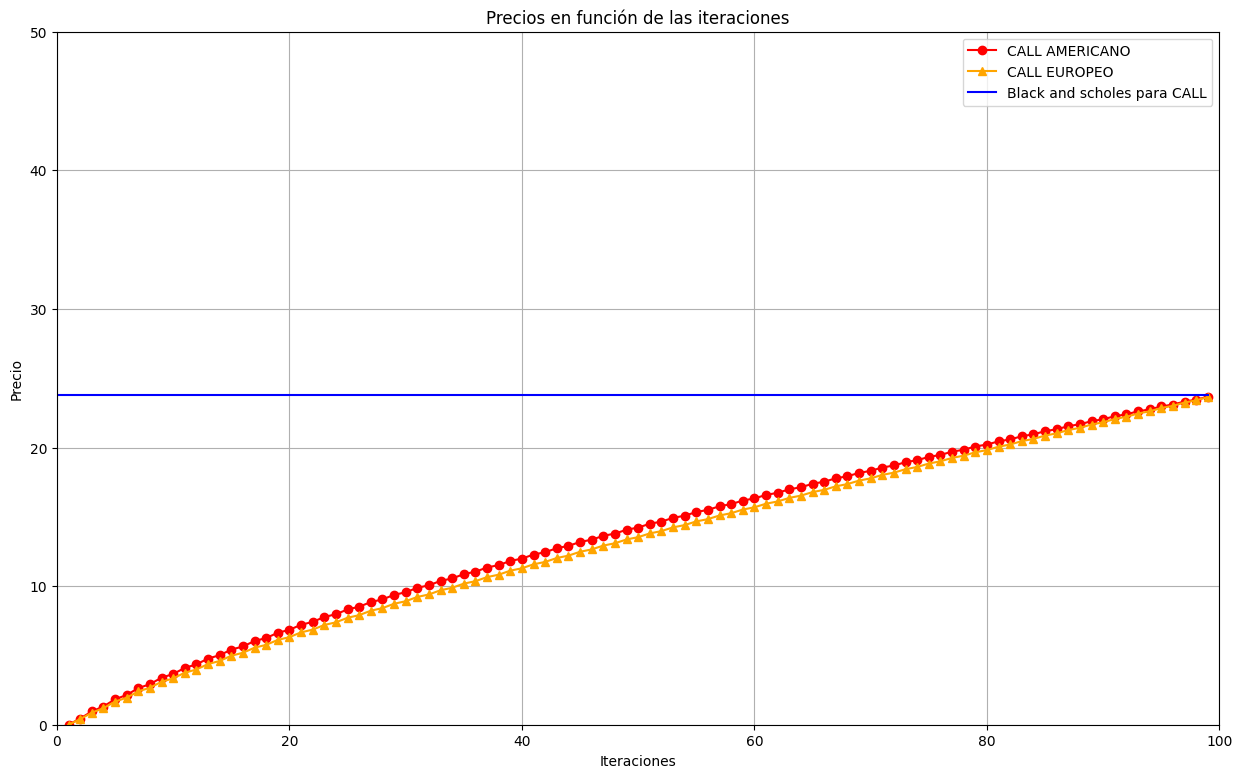

In [81]:
constante_y = opcion
x_values = range(100)
Valor_Black_Scholes = [constante_y] * len(x_values)
plt.figure(figsize=(15, 9))

plt.xlim(0, 100)
plt.ylim(0, 50)

plt.plot(range(1, n), precios_lista_a, marker='o', color='red', linestyle='-', label='CALL AMERICANO')
plt.plot(range(1, n), precios_lista_e, marker='^', color='orange', linestyle='-', label='CALL EUROPEO')
plt.plot(x_values, Valor_Black_Scholes, label='Black and scholes para CALL', color='blue')
plt.xlabel('Iteraciones')
plt.ylabel('Precio')
plt.title('Precios en función de las iteraciones')
plt.grid(True)
plt.legend()
plt.show()

#GRAFICA QUE MUESTRA LA CONVERGENCIA DE LAS PUT

In [82]:
precios_lista_e=[]
def calculos_grafica(calcular_opcion_europea, calcular_pagos_finales, calcular_arbol_precios, n):

    precios = calcular_arbol_precios(S_0, u, d, n)
    pagos_finales = calcular_pagos_finales(precios, n, k, 1)
    precio_e = calcular_opcion_europea(pagos_finales, n, p, r, vp, dt)

    precios_lista_e.append(precio_e)
    return precios_lista_e


for i in range(1, n):  # Realiza el cálculo para n = 1, 2 y 3
    precio_lista_e = calculos_grafica(calcular_opcion_europea, calcular_pagos_finales, calcular_arbol_precios, i)

#print(precios_lista_e)

In [83]:
precios_lista_a=[]
def calculos_grafica(calcular_opcion_americana, calcular_pagos_finales, calcular_arbol_precios, n):

    precios = calcular_arbol_precios(S_0, u, d, n)
    pagos_finales = calcular_pagos_finales(precios, n, k, 1)
    precio_a = calcular_opcion_americana(precios, n, k, pagos_finales, p, r, dt, 1)

    precios_lista_a.append(precio_a)
    return precios_lista_a


for i in range(1,n):  # Realiza el cálculo para n = 1, 2 y 3
    precio_lista_a = calculos_grafica(calcular_opcion_americana, calcular_pagos_finales, calcular_arbol_precios, i)

#print(precios_lista_a)

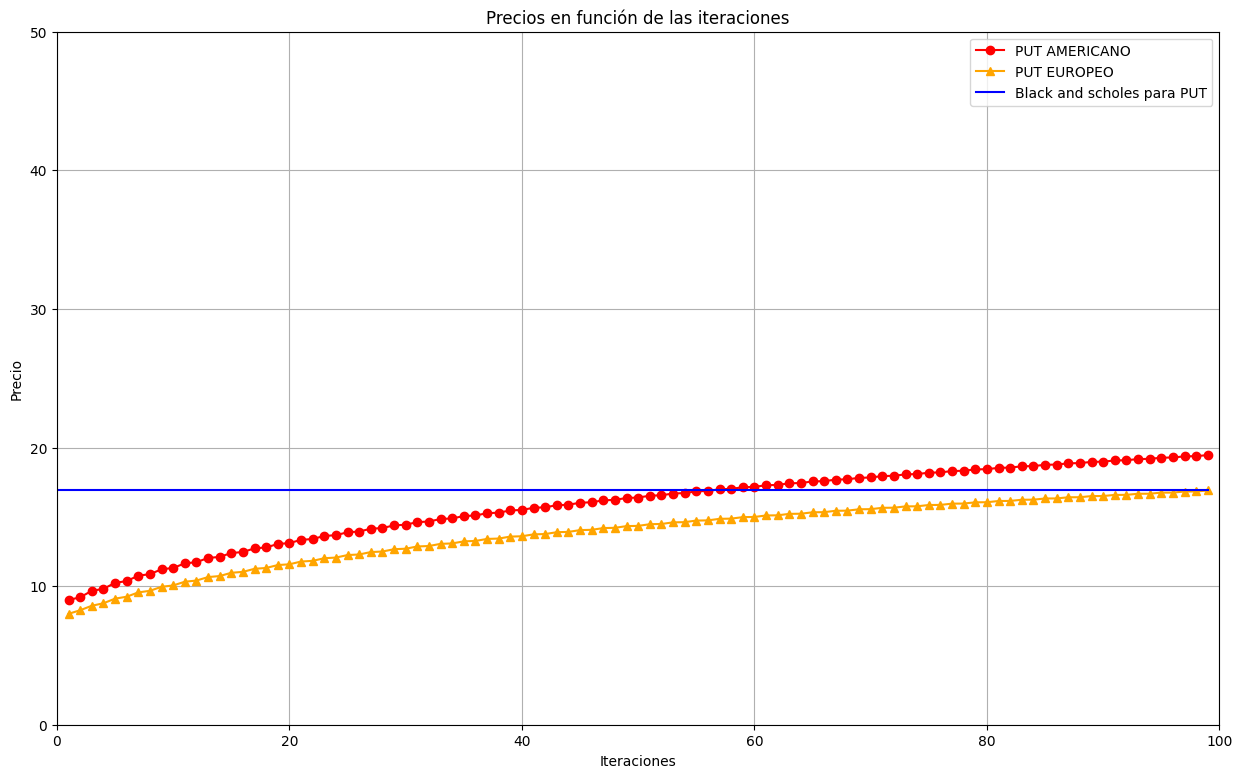

In [84]:
opcion = calculo_black_scholes(S_0, k, r, T, sigma, 'p')
constante_y = opcion
x_values = range(100)
Valor_Black_Scholes = [constante_y] * len(x_values)
plt.figure(figsize=(15, 9))

plt.xlim(0, 100)
plt.ylim(0, 50)

plt.plot(range(1, n), precios_lista_a, marker='o', color='red', linestyle='-', label='PUT AMERICANO')
plt.plot(range(1, n), precios_lista_e, marker='^', color='orange', linestyle='-', label='PUT EUROPEO')
plt.plot(x_values, Valor_Black_Scholes, label='Black and scholes para PUT', color='blue')
plt.xlabel('Iteraciones')
plt.ylabel('Precio')
plt.title('Precios en función de las iteraciones')
plt.grid(True)
plt.legend()
plt.show()